In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, use the LeNet CNN model
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Necessities imported!


In [2]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile
    from io import BytesIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(BytesIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
# Setup the paths for the necessary directories 
current_folder = os.path.join(os.getcwd(), 'Dataset')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

# Check if the data folder already exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Check if the training lmdb exists in the data folder
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
# Check if the testing lmdb exists in the data folder   
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# Attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

# Clean up statistics from any old runs
if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/mnt/f/Linux_home/Workspace/Caffe2/Dataset/tutorial_data/mnist
workspace root folder:/mnt/f/Linux_home/Workspace/Caffe2/Dataset/tutorial_files/tutorial_mnist


In [3]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [4]:
# Function to construct a MLP neural network
# The input 'model' is a model helper and 'data' is the input data blob's name
def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = brew.relu(model, layer, 'relu_{}'.format(i))
    softmax = brew.softmax(model, layer, 'softmax')
    return softmax

In [5]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

In [6]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

In [7]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [8]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

In [9]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

In [10]:
#### Train Model
# Specify the data will be input in NCHW order
#  (i.e. [batch_size, num_channels, height, width])
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
# Specify the input is from the train lmdb
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
softmax = AddModel(test_model, data)
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")

BlobReference("softmax")

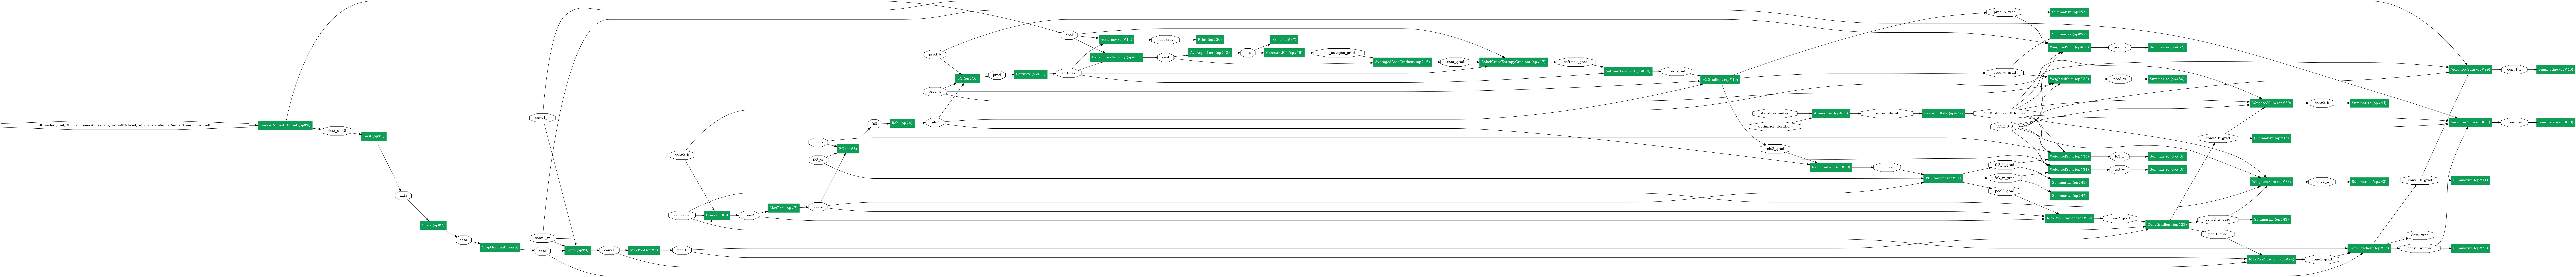

In [11]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

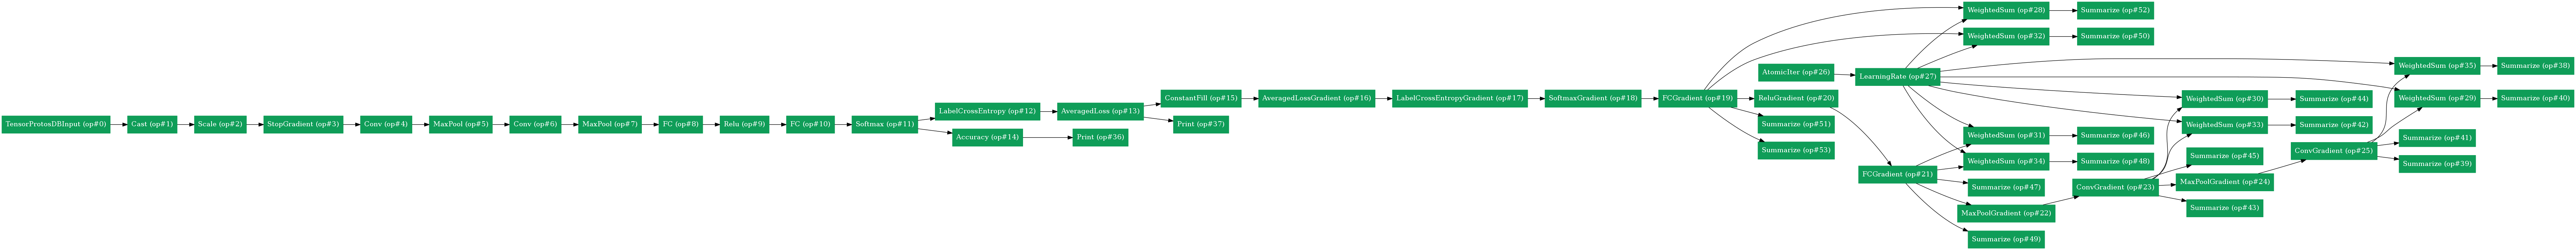

In [12]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

In [13]:
print("*******train_model.net.Proto()*******\n")
print(str(train_model.net.Proto())[:400] + '\n...')
print("\n*******train_model.param_init_net.Proto()*******\n")
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

*******train_model.net.Proto()*******

name: "mnist_train"
op {
  input: "dbreader_/mnt/f/Linux_home/Workspace/Caffe2/Dataset/tutorial_data/mnist/mnist-train-nchw-lmdb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "d
...

*******train_model.param_init_net.Proto()*******

name: "mnist_train_init"
op {
  output: "dbreader_/mnt/f/Linux_home/Workspace/Caffe2/Dataset/tutorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "lmdb"
  }
  arg {
    name: "db"
    s: "/mnt/f/Linux_home/Workspace/Caffe2/Dataset/tutorial_data/mnist/mnist-train-nchw-lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {

...


Iter: 0, Loss: 2.37674331665, Accuracy: 0.140625
Iter: 25, Loss: 0.458850413561, Accuracy: 0.875
Iter: 50, Loss: 0.322740077972, Accuracy: 0.875
Iter: 75, Loss: 0.316481858492, Accuracy: 0.890625
Iter: 100, Loss: 0.25754776597, Accuracy: 0.90625
Iter: 125, Loss: 0.249026015401, Accuracy: 0.90625
Iter: 150, Loss: 0.0943664312363, Accuracy: 0.984375
Iter: 175, Loss: 0.22562417388, Accuracy: 0.9375


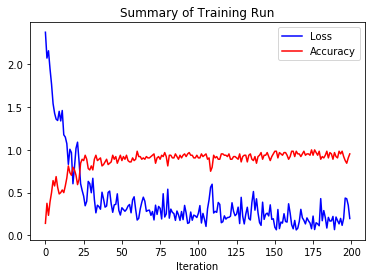

In [14]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

In [15]:
import caffe2
print(caffe2.__file__)

/usr/local/lib/python2.7/dist-packages/caffe2/__init__.py
